# MNIST with SciKit-Learn and skorch

The goal of skorch is to make it possible to use PyTorch with sklearn. This is achieved by providing a wrapper around PyTorch that has an sklearn interface.
Skorch does not re-invent the wheel, instead getting as much out of your way as possible. If you are familiar with sklearn and PyTorch, you don’t have to learn any new concepts, and the syntax should be well known. (If you’re not familiar with those libraries, it is worth getting familiarized.)

Additionally, skorch abstracts away the training loop, making a lot of boilerplate code obsolete. A simple net.fit(X, y) is enough. Out of the box, skorch works with many types of data, be it PyTorch Tensors, NumPy arrays, Python dicts, and so on. However, if you have other data, extending skorch is easy to allow for that.

<img src="https://cpp-learning.com/wp-content/uploads/2020/03/skorch_logo.jpg" width="1600">


In [1]:
!pip install skorch -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.3/239.3 kB 2.1 MB/s eta 0:00:00


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

## Loading Data
Using SciKit-Learns ```fetch_openml``` to load MNIST data.

In [3]:
mnist = fetch_openml('mnist_784', as_frame=False, cache=False)
mnist.data.shape

(70000, 784)

## Preprocessing Data

Each image of the MNIST dataset is encoded in a 784 dimensional vector, representing a 28 x 28 pixel image. Each pixel has a value between 0 and 255, corresponding to the grey-value of a pixel.<br />
The above ```featch_mldata``` method to load MNIST returns ```data``` and ```target``` as ```uint8``` which we convert to ```float32``` and ```int64``` respectively.

In [4]:
X = mnist.data.astype('float32') # Features
y = mnist.target.astype('int64') # Target

To avoid big weights that deal with the pixel values from between [0, 255], we scale `X` down. A commonly used range is [0, 1].

In [5]:
X = X/255.0

In [6]:
X.min(), X.max()

(0.0, 1.0)

Note: data is not normalized.

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.25,
                                                    random_state=667
                                                    )

In [8]:
#sum num row == total num row
assert(X_train.shape[0] + X_test.shape[0] == mnist.data.shape[0])

In [9]:
X_train.shape, y_train.shape

((52500, 784), (52500,))

### Print a selection of training images and their labels

In [10]:
def plot_example(X, y):
    """Plot the first 5 images and their labels in a row."""
    for i, (img, y) in enumerate(zip(X[:5].reshape(5, 28, 28), y[:5])):
        plt.subplot(151 + i)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
        plt.title(y)

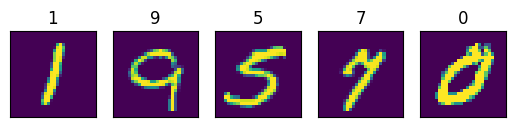

In [11]:
plot_example(X_train, y_train)

## Build Neural Network with PyTorch
Simple, fully connected neural network with one hidden layer. Input layer has 784 dimensions (28x28), hidden layer has 98 (= 784 / 8) and output layer 10 neurons, representing digits 0 - 9.

In [12]:
import torch
from torch import nn
import torch.nn.functional as F

In [13]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [14]:
mnist_dim = X.shape[1]
hidden_dim = int(mnist_dim/8)
output_dim = len(np.unique(mnist.target)) # 10 digits classes

In [15]:
mnist_dim, hidden_dim, output_dim

(784, 98, 10)

### A Neural network in PyTorch's (NO CONVOLUTION!!).

In [16]:
class ClassifierModule(nn.Module):
    def __init__(
                self,
                input_dim=mnist_dim,
                hidden_dim=hidden_dim,
                output_dim=output_dim,
                dropout=0.5,
                ):
        super(ClassifierModule, self).__init__()
        self.dropout = nn.Dropout(dropout)

        self.hidden = nn.Linear(input_dim, hidden_dim)
        self.output = nn.Linear(hidden_dim, output_dim)

    def forward(self, X, **kwargs):
        X = F.relu(self.hidden(X))
        X = self.dropout(X)
        X = F.softmax(self.output(X), dim=-1)
        return X

### With skorch

In [17]:
from skorch import NeuralNetClassifier
from skorch.callbacks import EpochScoring

torch.manual_seed(667)

model = NeuralNetClassifier(
                            ClassifierModule,
                            max_epochs=20,
                            lr=0.1,
                            device=device,
                            callbacks=[EpochScoring(scoring='accuracy', name='train_acc', on_train=True),], # plot accuracy
                            )

In [18]:
model.fit(X_train, y_train);

  epoch    train_acc    train_loss    valid_acc    valid_loss     dur
-------  -----------  ------------  -----------  ------------  ------
      1       0.7630        0.8352       0.8869        0.3993  1.6615
      2       0.8760        0.4373       0.9083        0.3224  1.6381
      3       0.8951        0.3683       0.9198        0.2765  0.9069
      4       0.9078        0.3253       0.9298        0.2510  0.8922
      5       0.9152        0.2974       0.9355        0.2279  0.8891
      6       0.9218        0.2774       0.9386        0.2108  0.8942
      7       0.9252        0.2584       0.9435        0.1941  0.9221
      8       0.9292        0.2451       0.9470        0.1846  0.9031
      9       0.9314        0.2351       0.9505        0.1738  0.9099
     10       0.9354        0.2237       0.9518        0.1674  0.9097
     11       0.9389        0.2161       0.9539        0.1616  0.9103
     12       0.9397        0.2080       0.9565        0.1586  0.9139
     13       0.9412

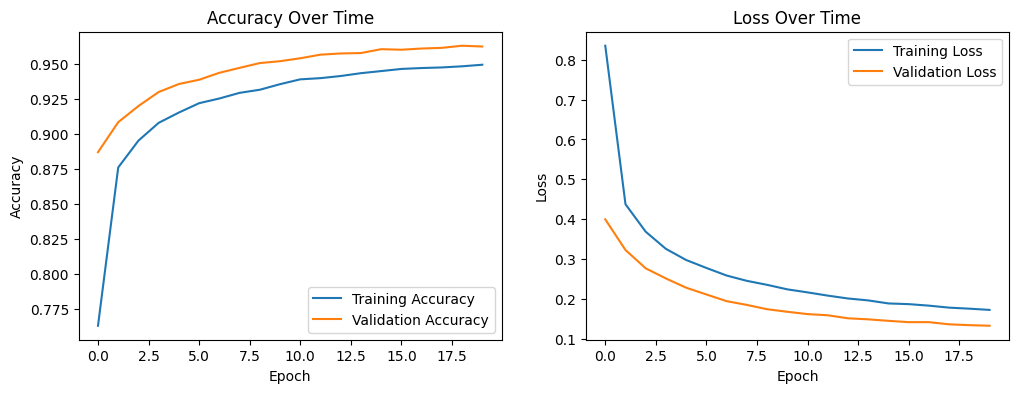

In [19]:
# Plot the loss and accuracy
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(model.history[:, 'train_acc'],label='Training Accuracy')
plt.plot(model.history[:, 'valid_acc'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Over Time')

plt.subplot(1, 2, 2)
plt.plot(model.history[:, 'train_loss'],label='Training Loss')
plt.plot(model.history[:, 'valid_loss'],label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Over Time')

plt.show()

## Prediction

In [20]:
from sklearn.metrics import accuracy_score

y_pred = model.predict(X_test)
accuracy_score(y_test, y_pred)

0.966

In [21]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98      1714
           1       0.97      0.99      0.98      1974
           2       0.97      0.96      0.97      1781
           3       0.95      0.97      0.96      1811
           4       0.96      0.97      0.97      1712
           5       0.96      0.95      0.96      1565
           6       0.98      0.97      0.98      1734
           7       0.97      0.97      0.97      1842
           8       0.96      0.94      0.95      1663
           9       0.96      0.95      0.95      1704

    accuracy                           0.97     17500
   macro avg       0.97      0.97      0.97     17500
weighted avg       0.97      0.97      0.97     17500



An accuracy of about 96% for a network with only one hidden layer is not too bad.

Let's take a look at some predictions that went wrong:

In [22]:
error_mask = y_pred != y_test

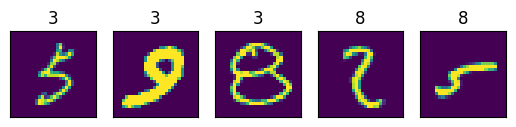

In [23]:
plot_example(X_test[error_mask], y_pred[error_mask])

## Neural network in PyTorch's with CONVOLUTION!!.
PyTorch expects a 4 dimensional tensor as input for its 2D convolution layer. The dimensions represent:
* Batch size
* Number of channel
* Height
* Width

As initial batch size the number of examples needs to be provided. MNIST data has only one channel. As stated above, each MNIST vector represents a 28x28 pixel image. Hence, the resulting shape for PyTorch tensor needs to be (x, 1, 28, 28).

In [24]:
XCnn = X.reshape(-1, 1, 28, 28) ## (batch,channel,height, width)

In [25]:
XCnn.shape

(70000, 1, 28, 28)

In [26]:
XCnn_train, XCnn_test, y_train, y_test = train_test_split(XCnn, y,
                                                          test_size=0.25,
                                                          random_state=667
                                                          )

In [27]:
XCnn_train.shape, y_train.shape

((52500, 1, 28, 28), (52500,))

In [28]:
## with convolution

class Cnn(nn.Module):
    def __init__(self, dropout=0.5):
        super(Cnn, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.conv2_drop = nn.Dropout2d(p=dropout)
        self.fc1 = nn.Linear(1600, 100) # 1600 = number channels * width * height
        self.fc2 = nn.Linear(100, 10)
        self.fc1_drop = nn.Dropout(p=dropout)

    def forward(self, x):
        x = torch.relu(F.max_pool2d(self.conv1(x), 2))
        x = torch.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))

        # flatten over channel, height and width = 1600
        x = x.view(-1, x.size(1) * x.size(2) * x.size(3))
        x = torch.relu(self.fc1_drop(self.fc1(x)))
        x = torch.softmax(self.fc2(x), dim=-1)
        return x

In [29]:
from skorch import NeuralNetClassifier
from skorch.callbacks import EpochScoring

torch.manual_seed(667)
model_cnn = NeuralNetClassifier(
                                Cnn,
                                max_epochs=10,
                                lr=0.002,
                                optimizer=torch.optim.Adam,
                                device=device,
                                callbacks=[EpochScoring(scoring='accuracy', name='train_acc', on_train=True),], # plor accuracy
                                )

In [30]:
model_cnn.fit(XCnn_train, y_train);

  epoch    train_acc    train_loss    valid_acc    valid_loss     dur
-------  -----------  ------------  -----------  ------------  ------
      1       0.8424        0.4907       0.9702        0.0937  2.4881
      2       0.9445        0.1881       0.9780        0.0688  1.5715
      3       0.9551        0.1513       0.9808        0.0605  1.5823
      4       0.9609        0.1279       0.9835        0.0533  1.7851
      5       0.9647        0.1202       0.9853        0.0497  1.7238
      6       0.9670        0.1099       0.9860        0.0485  1.5693
      7       0.9686        0.1045       0.9867        0.0450  1.5706
      8       0.9701        0.0985       0.9867        0.0462  1.5643
      9       0.9718        0.0936       0.9869        0.0447  1.5720
     10       0.9730        0.0872       0.9870        0.0432  1.5674


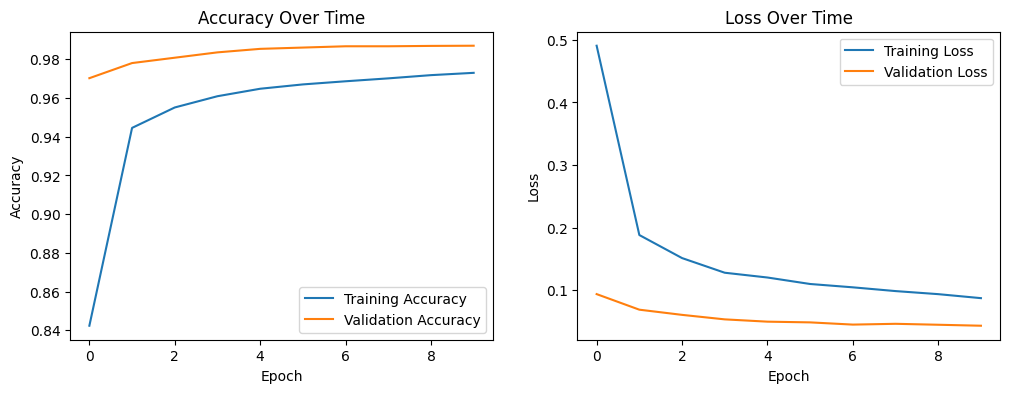

In [32]:
# Plot the loss and accuracy
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(model_cnn.history[:, 'train_acc'],label='Training Accuracy')
plt.plot(model_cnn.history[:, 'valid_acc'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Over Time')

plt.subplot(1, 2, 2)
plt.plot(model_cnn.history[:, 'train_loss'],label='Training Loss')
plt.plot(model_cnn.history[:, 'valid_loss'],label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Over Time')

plt.show()

In [33]:
y_pred_cnn = model_cnn.predict(XCnn_test)
accuracy_score(y_test, y_pred_cnn)

0.9897714285714285

In [34]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98      1714
           1       0.97      0.99      0.98      1974
           2       0.97      0.96      0.97      1781
           3       0.95      0.97      0.96      1811
           4       0.96      0.97      0.97      1712
           5       0.96      0.95      0.96      1565
           6       0.98      0.97      0.98      1734
           7       0.97      0.97      0.97      1842
           8       0.96      0.94      0.95      1663
           9       0.96      0.95      0.95      1704

    accuracy                           0.97     17500
   macro avg       0.97      0.97      0.97     17500
weighted avg       0.97      0.97      0.97     17500



An accuracy of >98% should suffice for this example!

Let's see how we fare on the examples that went wrong before:

In [ ]:
error_mask = y_pred_cnn != y_test
accuracy_score(y_test[error_mask], y_pred_cnn[error_mask])

0.0

Over 70% of the previously misclassified images are now correctly identified.

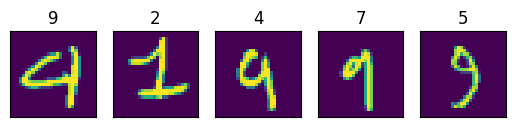

In [ ]:
plot_example(X_test[error_mask], y_pred_cnn[error_mask])